In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
# Defaults from 'sourmash index'

import glob
import itertools
import math
import os

import igraph as ig
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

ksize = 21
moltype = 'DNA'

ignore_abundance = False
downsample = False

bf_size = 1e5
n_children = 2
scaled = False

n_neighbors = 3


from sourmash import signature as sig
from sourmash.compare import compare_all_pairs
from sourmash.index import build_sbt
from sourmash.sbt import Leaf
from sourmash.sbtmh import SigLeaf, create_sbt_index
from sourmash import sourmash_args
from sourmash.logging import notify

# from sourmash import umap

import khtools

from umap import UMAP


In [3]:
annotations = pd.read_csv('s3://kmer-hashing/lung_adenocarcinoma/cell_annotations/tumor_annotations_original.csv', 
                          index_col=0)
print(annotations.shape)
annotations.head()

(5109, 2)


,cell_id,inferCNV_annotation
A10_1001000407,A10_1001000407,tumor
A10_B000863,A10_B000863,nontumor
A11_B000860,A11_B000860,nontumor
A12_B003103,A12_B003103,nontumor
A15_B000420,A15_B000420,nontumor


In [4]:
annotations['plate'] = annotations['cell_id'].str.split("_").str[-1]
annotations.head()

,cell_id,inferCNV_annotation,plate
A10_1001000407,A10_1001000407,tumor,1001000407
A10_B000863,A10_B000863,nontumor,B000863
A11_B000860,A11_B000860,nontumor,B000860
A12_B003103,A12_B003103,nontumor,B003103
A15_B000420,A15_B000420,nontumor,B000420


In [5]:
annotations.groupby('plate').size()

plate
10001000325    20
1001000292      1
1001000293      1
1001000295      1
1001000302      4
               ..
B003777        96
B003894        36
B003920        30
B003930        16
B003995        76
Length: 121, dtype: int64

In [6]:

folder = '/home/olga/pureScratch/kmer-hashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/'

ksize = 27
molecule = "DNA"

sketch_id = f'molecule-{molecule.lower()}_ksize-{ksize}_log2sketchsize-12'
all_signatures = glob.glob(f'{folder}/*{sketch_id}.sig')
print(len(all_signatures))
basenames = [os.path.basename(x) for x in all_signatures]
# print(len)
basenames[:10]


annotated_files = list(itertools.chain(*[[x for x in basenames if x.startswith(cell_id)] for cell_id in annotations.index]))
print(len(annotated_files))
annotated_files[:10]

annotated_full_path = [folder + x for x in annotated_files]
print(len(annotated_full_path))
annotated_full_path[:10]

3073
671
671


['/home/olga/pureScratch/kmer-hashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/A10_1001000407_molecule-dna_ksize-27_log2sketchsize-12.sig',
 '/home/olga/pureScratch/kmer-hashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/A11_B000860_molecule-dna_ksize-27_log2sketchsize-12.sig',
 '/home/olga/pureScratch/kmer-hashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/A1_B000860_molecule-dna_ksize-27_log2sketchsize-12.sig',
 '/home/olga/pureScratch/kmer-hashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/A1_B000883_molecule-dna_ksize-27_log2sketchsize-12.sig',
 '/home/olga/pureScratch/kmer-hashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/A22_B003071_molecule-dna_ksize-27_log2sketchsize-12.sig',
 '/home/olga/pureScratch/kmer-hashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/A22_B003775_molecule-dna_ksize-27_log2sketchsize-12.sig',
 '/home/olga/pureScratch/kmer-hashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/A2_1001000412_molecule-dna_ksize-27_log2sketchsiz

In [7]:
basenames[:10]

['A10_1001000296_molecule-dna_ksize-27_log2sketchsize-12.sig',
 'A10_1001000295_molecule-dna_ksize-27_log2sketchsize-12.sig',
 'A10_1001000329_molecule-dna_ksize-27_log2sketchsize-12.sig',
 'A10_1001000293_molecule-dna_ksize-27_log2sketchsize-12.sig',
 'A10_1001000409_molecule-dna_ksize-27_log2sketchsize-12.sig',
 'A10_1001000407_molecule-dna_ksize-27_log2sketchsize-12.sig',
 'A10_B000420_molecule-dna_ksize-27_log2sketchsize-12.sig',
 'A10_1001000410_molecule-dna_ksize-27_log2sketchsize-12.sig',
 'A10_B001016_molecule-dna_ksize-27_log2sketchsize-12.sig',
 'A10_1001000408_molecule-dna_ksize-27_log2sketchsize-12.sig']

In [8]:
cells_without_signatures = sorted([cell_id for cell_id in annotations.index if not any(x for x in basenames if x.startswith(cell_id))])
len(cells_without_signatures)
cells_without_signatures[:5]

['A10_B000863', 'A10_B003518', 'A10_B003523', 'A10_B003527', 'A10_B003528']

In [9]:
annotations_no_signature = annotations.loc[cells_without_signatures]
annotations_no_signature.groupby('plate').size()

plate
10001000325     8
1001000292      1
1001000293      1
1001000295      1
1001000302      3
               ..
B003777        82
B003894        34
B003920        29
B003930        16
B003995        76
Length: 119, dtype: int64

In [11]:
# 'A10_B000420_molecule-dna_ksize-27_log2sketchsize-12.sig'.startswith()

In [13]:
# ksize = 27
# tree = build_sbt(annotated_full_path, ksize=ksize, moltype="DNA")

In [ ]:
# %%time

# lung_adeno_signatures = []
# for filename in annotated_full_path:
#      lung_adeno_signatures.extend(sig.load_signatures(filename, ksize=ksize, select_moltype="DNA", do_raise=True))
# print(len(lung_adeno_signatures))
# lung_adeno_signatures[:5]



# # %debug

# columns = [x.name() for x in lung_adeno_signatures]
# print(len(columns))
# columns[:5]

# annotations_subset = annotations.loc[columns]
# print(annotations_subset.shape)
# annotations_subset.head()

# # pd.options.display.max_rows = 500
# # annotations_no_signature.groupby('plate').size()

# # annotations.groupby('plate').size() - annotations_subset.groupby('plate').size()

# similarities_ignore_abundanceTrue = compare_all_pairs(lung_adeno_signatures, ignore_abundance=True, n_jobs=32)

# similarities_df = pd.DataFrame(similarities_ignore_abundanceTrue, index=columns, columns=columns)
# print(similarities_df.shape)
# similarities_df.head()

# annotations_subset.head()

# color_cols = [#'tissue', 'subtissue', 
#               'inferCNV_annotation', ]
# palette_names = [#'tab20', 'tab10',
#                  'Set2', ]
# palettes = dict(zip(color_cols, palette_names))
# palettes

# %%time

# key = f'k{ksize}_without_abundance'

# n_neighbors = 5
# figure_folder = 's3://kmer-hashing/lung_adeno/figures/'
# figure_prefix = f'molecule={moltype}_ksize={ksize}_ignore-abundance={ignore_abundance}'
# title = 'Lung Adeno'

# g, pos = khtools.knn.build_graph_and_plot(similarities_df, annotations_subset, n_neighbors,
#                                           color_cols, palettes, figure_folder, figure_prefix, title)

# # graphs[key] = g
# # positions[key] = pos

## Iterate over multiple ksizes, molecules, etc

--- ksize: 21, molecule: DNA ---
3101


Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap
Setting similarities completedr index 664 done in 0.00000 seconds
Time taken to compare all pairs parallely is 19.16010 seconds 


--- ksize: 21, molecule: protein ---
3122


Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap
Setting similarities completedr index 683 done in 0.00001 secondstting similarities matrix for index 6 done in 0.00047 secondsSetting similarities matrix for index 330 done in 0.00031 seconds
Time taken to compare all pairs parallely is 20.55473 seconds 


--- ksize: 27, molecule: DNA ---
3093


Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap
Setting similarities completedr index 673 done in 0.00000 seconds
Time taken to compare all pairs parallely is 19.45979 seconds 


--- ksize: 27, molecule: protein ---
3087


Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap
Setting similarities completedr index 666 done in 0.00000 secondsetting similarities matrix for index 16 done in 0.00041 seconds
Time taken to compare all pairs parallely is 19.83713 seconds 


--- ksize: 33, molecule: DNA ---
1287


Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap
Setting similarities completedr index 266 done in 0.00000 secondsetting similarities matrix for index 86 done in 0.00013 seconds
Time taken to compare all pairs parallely is 6.81109 seconds 


--- ksize: 33, molecule: protein ---
1300


Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap
Setting similarities completedr index 261 done in 0.00001 seconds
Time taken to compare all pairs parallely is 6.88041 seconds 


--- ksize: 51, molecule: DNA ---
1297


Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap
Setting similarities completedr index 269 done in 0.00001 seconds
Time taken to compare all pairs parallely is 6.76910 seconds 


--- ksize: 51, molecule: protein ---
1293


Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap
Setting similarities completedr index 263 done in 0.00000 seconds
Time taken to compare all pairs parallely is 6.66258 seconds 


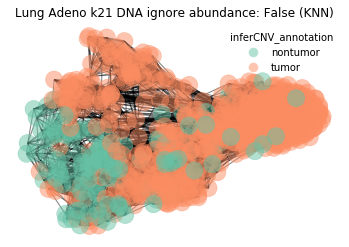

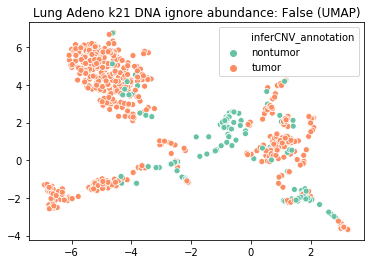

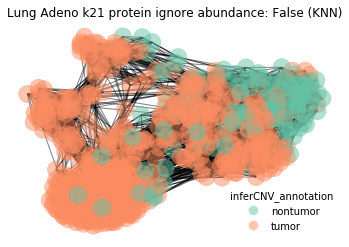

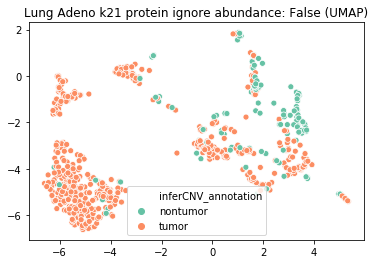

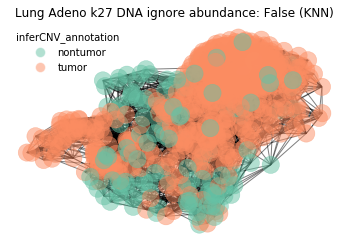

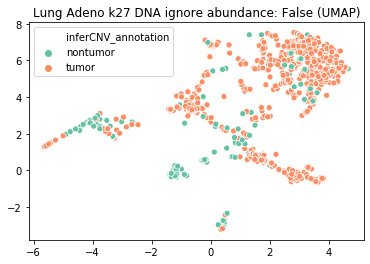

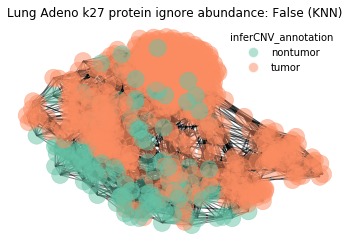

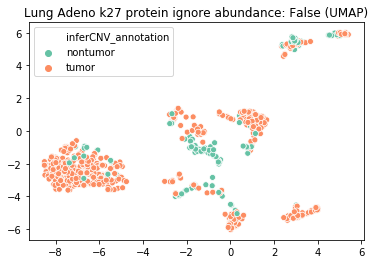

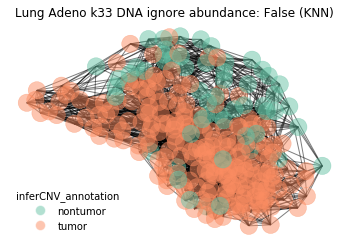

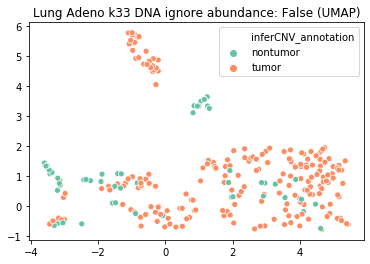

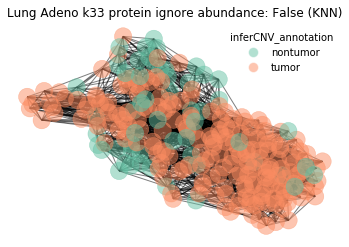

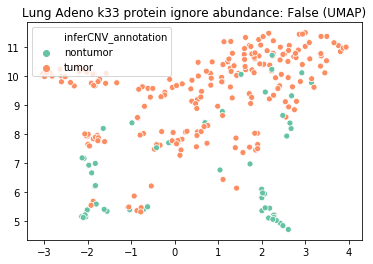

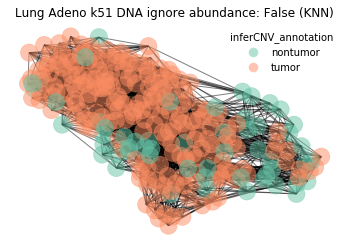

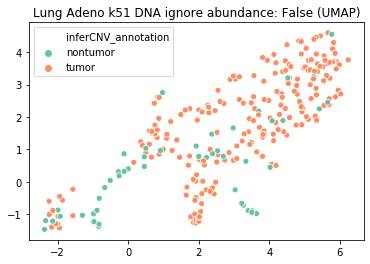

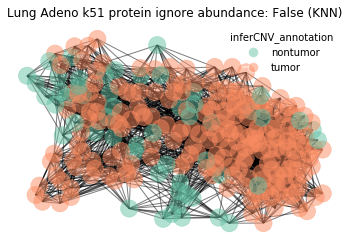

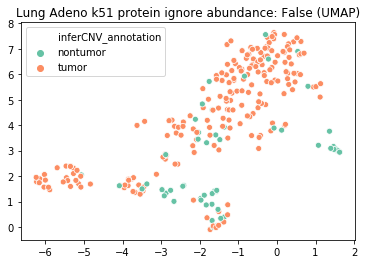

In [30]:
ksizes = 21, 27, 33, 51
molecules = "DNA", 'protein'#, 'dayhoff'
ignore_abundances = True, False
ignore_abundance = Treu

def load_signatures(signature_filelist, ksize, moltype):
    signatures = []
    for filename in signature_filelist:
         signatures.extend(sig.load_signatures(filename, ksize=ksize, select_moltype=moltype))
    return signatures

color_cols = [#'tissue', 'subtissue', 
              'inferCNV_annotation', ]
palette_names = [#'tab20', 'tab10',
                 'Set2', ]
palettes = dict(zip(color_cols, palette_names))
palettes


folder = '/home/olga/pureScratch/kmer-hashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/'

for ksize, molecule in itertools.product(ksizes, molecules):
    print(f"--- ksize: {ksize}, molecule: {molecule} ---")

    sketch_id = f'molecule-{molecule.lower()}_ksize-{ksize}_log2sketchsize-12'
    sketch_id_signatures = glob.glob(f'{folder}/*{sketch_id}.sig')
    print(len(sketch_id_signatures))
    basenames = [os.path.basename(x) for x in sketch_id_signatures]
    annotated_files = list(itertools.chain(*[[folder + x for x in basenames if x.startswith(cell_id)] for cell_id in annotations.index]))
    signatures = load_signatures(annotated_files, ksize, molecule)
    if len(signatures) == 0:
        print("no signatures loaded! continuing on to next")
        continue
    print(f"len(signatures): len(signatures)")
    
    cells = [x.name() for x in signatures]
    annotations_subset = annotations.loc[cells]
    
#     for ignore_abundance in ignore_abundances:
    matrix = compare_all_pairs(signatures, ignore_abundance=True, n_jobs=32)
    df = pd.DataFrame(matrix, index=cells, columns=cells)

    n_neighbors = 15
    figure_folder = 's3://kmer-hashing/lung_adeno/figures/'
    figure_prefix = f'{sketch_id}_ignore-abundance={ignore_abundance}'
    title = f'Lung Adeno k{ksize} {molecule} ignore abundance: {ignore_abundance}'

    g, pos = khtools.knn.build_graph_and_plot(df, annotations_subset, n_neighbors,
                                              color_cols, palettes, figure_folder, figure_prefix, title + " (KNN)")
    
    
    umapper = UMAP(metric='precomputed', n_neighbors=5)
    embedding = umapper.fit_transform(1-df)

    x = embedding[:, 0]
    y = embedding[:, 1]

    for col in color_cols:
        hue = annotations.loc[cells, col]

        fig, ax = plt.subplots(figsize=(6, 4))

        sns.scatterplot(x, y, hue=hue, palette='Set2', hue_order=['nontumor', 'tumor'])
        ax.set(title=title + " (UMAP)")

In [ ]:
ignore_abundance = False
downsample = False

n_neighbors = 5

umapper = UMAP(n_neighbors=n_neighbors, metric='precomputed')

embedding = umapper.fit_transform(df)

print(embedding.shape)


fig, ax = plt.subplots(figsize=(6, 4))

x = embedding[:, 0]
y = embedding[:, 1]
sns.scatterplot(x, y, hue=annotations_subset['inferCNV_annotation'], palette='Set2')

sum(1 for _ in tree.leaves())

len(tree.nodes)

In [12]:
# tree.nodes

In [13]:
# [node.data for node in tree.nodes.values()]

In [14]:
adjacencies = tree.nearest_neighbors(n_neighbors=n_neighbors, 
                                  ignore_abundance=ignore_abundance,
                                 downsample=downsample)
print(len(adjacencies))

2001


In [ ]:
sum(1 for _ in tree.leaves())

In [ ]:
sum(1 for _ in tree._leaves())

In [ ]:
leaves = list(tree.leaves())
len(leaves)

In [ ]:
len(tree.nodes)

In [ ]:
tree.missing_nodes

In [ ]:
n_neighbors

In [ ]:
adjac

## Ignore abundance = False

### Spectral initialization (default)

In [ ]:
ignore_abundance = False
downsample = False

n_neighbors = 5

umapper = umap.UMAP(n_neighbors=n_neighbors, ignore_abundance=ignore_abundance, downsample=downsample)

%time embedding = umapper.fit_transform(tree)

print(embedding.shape)



fig, ax = plt.subplots(figsize=(6, 4))

x = embedding[:, 0]
y = embedding[:, 1]
sns.scatterplot(x, y, hue=annotations_subset['inferCNV_annotation'], palette='Set2')

### Random initialization

In [ ]:
ignore_abundance = False
downsample = False

n_neighbors = 5

umapper = umap.UMAP(n_neighbors=n_neighbors, ignore_abundance=ignore_abundance, downsample=downsample, init='random')

%time embedding = umapper.fit_transform(tree)

print(embedding.shape)

annotations_subset = annotations.loc[cells]
print(annotations_subset.shape)
annotations_subset.head()

fig, ax = plt.subplots(figsize=(6, 4))

x = embedding[:, 0]
y = embedding[:, 1]
sns.scatterplot(x, y, hue=annotations_subset['inferCNV_annotation'], palette='Set2')

## Ignore_abundance = True

### Spectral initialization

In [ ]:
ignore_abundance = True
downsample = False

n_neighbors = 5

umapper = umap.UMAP(n_neighbors=n_neighbors, ignore_abundance=ignore_abundance, downsample=downsample)

%time embedding = umapper.fit_transform(tree)

print(embedding.shape)

annotations_subset = annotations.loc[cells]
print(annotations_subset.shape)
annotations_subset.head()

fig, ax = plt.subplots(figsize=(6, 4))

x = embedding[:, 0]
y = embedding[:, 1]
sns.scatterplot(x, y, hue=annotations_subset['inferCNV_annotation'], palette='Set2')

In [7]:
basenames

[]

## Do graph embedding

In [19]:
adjacencies = tree.nearest_neighbors(n_neighbors=n_neighbors, 
                                  ignore_abundance=ignore_abundance,
                                 downsample=downsample)
print(len(adjacencies))

leaves = list(set([u for u, v, weight in adjacencies]))
leaves[:10]

In [26]:
leaf_to_index = {leaf: i for i, leaf in enumerate(set([u for u, v, weight in adjacencies]))}
len(leaf_to_index)

667

In [30]:

adjacencies = tree.nearest_neighbors(n_neighbors=n_neighbors, 
                                  ignore_abundance=ignore_abundance,
                                 downsample=downsample)
print(len(adjacencies))

leaves = list(set([u for u, v, weight in adjacencies]))
leaves[:10]

g = ig.Graph(directed=True)
g.add_vertices([u for u in leaves])  # this adds n_leaves vertices
g.add_edges([(u, v) for (u, v, weight) in adjacencies])
g.es['weight'] = [weight for (u, v, weight) in adjacencies]
g

In [31]:
len(g.vs)

667

In [32]:
%%time

layout = g.layout_fruchterman_reingold()

CPU times: user 1.22 s, sys: 4 ms, total: 1.22 s
Wall time: 1.21 s


In [ ]:
1+1

In [ ]:

adjacencies = tree.nearest_neighbors(n_neighbors=15, 
                                  ignore_abundance=False,
                                 downsample=downsample)
print(len(adjacencies))

leaves = list(set([u for u, v, weight in adjacencies]))
leaves[:10]

g = ig.Graph(directed=True)
g.add_vertices([u for u in leaves])  # this adds n_leaves vertices
g.add_edges([(u, v) for (u, v, weight) in adjacencies])
g.es['weight'] = [weight for (u, v, weight) in adjacencies]
layout = g.layout_fruchterman_reingold()
graph_embedding = np.array(layout.coords)
fig, ax = plt.subplots(figsize=(6, 4))

x = graph_embedding[:, 0]
y = graph_embedding[:, 1]
sns.scatterplot(x, y, hue=annotations_subset['inferCNV_annotation'], palette='Set2')

In [ ]:
vertex_clolor